# Steering Vector Results Analysis

Analyzing sentiment steering across Qwen3 model sizes (0.6B to 32B).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

RESULTS_DIR = Path("../results")

## 1. Load Data

In [2]:
# Load combined summary
summary = pd.read_csv(RESULTS_DIR / "all_models_summary.csv")

# Order model sizes properly
size_order = ["0.6B", "1.7B", "4B", "8B", "14B", "32B"]
summary["model_size"] = pd.Categorical(summary["model_size"], categories=size_order, ordered=True)
summary = summary.sort_values(["model_size", "strength"])

print(f"Models: {summary['model_size'].unique().tolist()}")
print(f"Strengths: {sorted(summary['strength'].unique())}")
print(f"\nSamples per condition: {summary['n_samples'].iloc[0]}")

Models: ['0.6B', '1.7B', '4B', '8B', '14B', '32B']
Strengths: [np.float64(-1.0), np.float64(-0.5), np.float64(-0.25), np.float64(-0.1), np.float64(0.0), np.float64(0.1), np.float64(0.25), np.float64(0.5), np.float64(1.0)]

Samples per condition: 50


In [3]:
# Pivot for easy viewing
pivot = summary.pivot_table(
    index="model_size",
    columns="strength",
    values="mean_p_positive",
)
print("Mean P(Positive) by Model Size and Steering Strength:")
pivot.round(3)

Mean P(Positive) by Model Size and Steering Strength:


/tmp/ipykernel_1813190/1766048204.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = summary.pivot_table(


strength,-1.00,-0.50,-0.25,-0.10,0.00,0.10,0.25,0.50,1.00
model_size,,,,,,,,,
0.6B,0.032,0.001,0.004,0.127,0.512,0.926,0.956,1.000,0.851
1.7B,0.069,0.050,0.001,0.197,0.482,0.805,0.799,0.950,0.658
4B,0.256,0.083,0.037,0.171,0.591,0.854,0.881,0.891,0.126
8B,0.237,0.039,0.002,0.134,0.715,0.848,0.958,0.958,0.567
14B,0.119,0.131,0.022,0.081,0.579,0.860,0.980,1.000,0.410
32B,0.035,0.037,0.021,0.076,0.750,0.826,0.955,1.000,0.138


In [4]:
# Delta from baseline
pivot_delta = summary.pivot_table(
    index="model_size",
    columns="strength",
    values="delta_from_baseline",
)
print("Delta P(Positive) from Baseline (strength=0):")
pivot_delta.round(3)

Delta P(Positive) from Baseline (strength=0):


/tmp/ipykernel_1813190/2620190563.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_delta = summary.pivot_table(


strength,-1.00,-0.50,-0.25,-0.10,0.00,0.10,0.25,0.50,1.00
model_size,,,,,,,,,
0.6B,-0.479,-0.510,-0.507,-0.384,0.0,0.414,0.445,0.488,0.339
1.7B,-0.414,-0.432,-0.481,-0.286,0.0,0.323,0.317,0.468,0.176
4B,-0.334,-0.508,-0.553,-0.420,0.0,0.263,0.290,0.300,-0.465
8B,-0.477,-0.675,-0.712,-0.581,0.0,0.133,0.244,0.244,-0.148
14B,-0.460,-0.448,-0.557,-0.498,0.0,0.281,0.401,0.421,-0.169
32B,-0.715,-0.713,-0.729,-0.673,0.0,0.076,0.205,0.250,-0.612


## 2. Steering Effect Curves

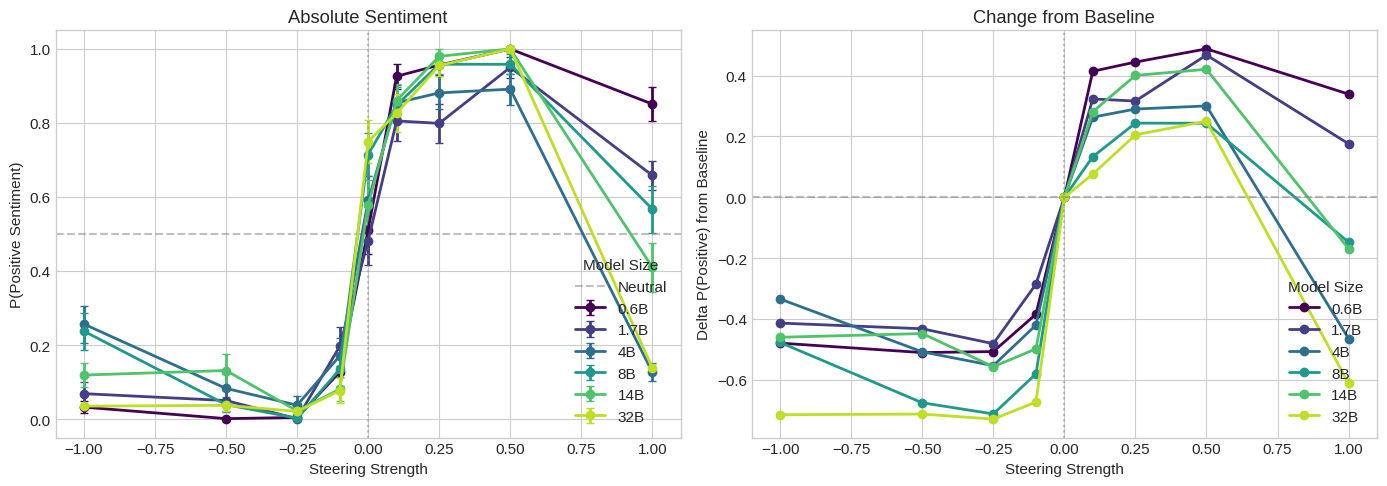

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

colors = plt.cm.viridis(np.linspace(0, 0.9, len(size_order)))

# Plot 1: Absolute P(Positive)
ax = axes[0]
for i, size in enumerate(size_order):
    data = summary[summary["model_size"] == size]
    ax.errorbar(
        data["strength"],
        data["mean_p_positive"],
        yerr=data["std_p_positive"] / np.sqrt(data["n_samples"]),  # SEM
        marker="o",
        label=size,
        color=colors[i],
        capsize=3,
        linewidth=2,
        markersize=6,
    )

ax.axhline(y=0.5, color="gray", linestyle="--", alpha=0.5, label="Neutral")
ax.axvline(x=0, color="gray", linestyle=":", alpha=0.5)
ax.set_xlabel("Steering Strength")
ax.set_ylabel("P(Positive Sentiment)")
ax.set_title("Absolute Sentiment")
ax.set_ylim(-0.05, 1.05)
ax.legend(title="Model Size", loc="lower right")

# Plot 2: Delta from Baseline
ax = axes[1]
for i, size in enumerate(size_order):
    data = summary[summary["model_size"] == size]
    ax.plot(
        data["strength"],
        data["delta_from_baseline"],
        marker="o",
        label=size,
        color=colors[i],
        linewidth=2,
        markersize=6,
    )

ax.axhline(y=0, color="gray", linestyle="--", alpha=0.5)
ax.axvline(x=0, color="gray", linestyle=":", alpha=0.5)
ax.set_xlabel("Steering Strength")
ax.set_ylabel("Delta P(Positive) from Baseline")
ax.set_title("Change from Baseline")
ax.legend(title="Model Size", loc="lower right")

plt.tight_layout()
plt.savefig(RESULTS_DIR / "steering_curves.png", dpi=150, bbox_inches="tight")
plt.show()

## 3. Optimal Steering Strength

In [6]:
# Find optimal strength for each model (max delta for positive steering)
positive_strengths = summary[summary["strength"] > 0]

optimal = positive_strengths.loc[
    positive_strengths.groupby("model_size")["delta_from_baseline"].idxmax()
][["model_size", "strength", "delta_from_baseline", "mean_p_positive"]]

optimal.columns = ["Model", "Optimal Strength", "Max Delta", "P(Positive)"]
print("Optimal Positive Steering Strength per Model:")
optimal.round(3)

Optimal Positive Steering Strength per Model:


/tmp/ipykernel_1813190/2505028795.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  positive_strengths.groupby("model_size")["delta_from_baseline"].idxmax()


,Model,Optimal Strength,Max Delta,P(Positive)
7,0.6B,0.50,0.488,1.000
16,1.7B,0.50,0.468,0.950
25,4B,0.50,0.300,0.891
33,8B,0.25,0.244,0.958
43,14B,0.50,0.421,1.000
52,32B,0.50,0.250,1.000


In [7]:
# Same for negative steering
negative_strengths = summary[summary["strength"] < 0]

optimal_neg = negative_strengths.loc[
    negative_strengths.groupby("model_size")["delta_from_baseline"].idxmin()
][["model_size", "strength", "delta_from_baseline", "mean_p_positive"]]

optimal_neg.columns = ["Model", "Optimal Strength", "Max Negative Delta", "P(Positive)"]
print("Optimal Negative Steering Strength per Model:")
optimal_neg.round(3)

Optimal Negative Steering Strength per Model:


/tmp/ipykernel_1813190/196825368.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  negative_strengths.groupby("model_size")["delta_from_baseline"].idxmin()


,Model,Optimal Strength,Max Negative Delta,P(Positive)
1,0.6B,-0.50,-0.510,0.001
11,1.7B,-0.25,-0.481,0.001
20,4B,-0.25,-0.553,0.037
29,8B,-0.25,-0.712,0.002
38,14B,-0.25,-0.557,0.022
47,32B,-0.25,-0.729,0.021


## 4. Steering Sensitivity vs Model Scale

In [8]:
# Extract key metrics per model
model_metrics = []

for size in size_order:
    data = summary[summary["model_size"] == size]
    
    # Get values at specific strengths
    baseline = data[data["strength"] == 0.0]["mean_p_positive"].values[0]
    at_05 = data[data["strength"] == 0.5]["mean_p_positive"].values[0]
    at_neg05 = data[data["strength"] == -0.5]["mean_p_positive"].values[0]
    at_1 = data[data["strength"] == 1.0]["mean_p_positive"].values[0]
    
    # Max effect (positive direction)
    max_delta = data[data["strength"] > 0]["delta_from_baseline"].max()
    max_delta_strength = data[data["strength"] > 0].loc[
        data[data["strength"] > 0]["delta_from_baseline"].idxmax(), "strength"
    ]
    
    num_layers = data["num_layers"].iloc[0]
    
    model_metrics.append({
        "model_size": size,
        "num_layers": num_layers,
        "baseline_p_pos": baseline,
        "p_pos_at_0.5": at_05,
        "p_pos_at_-0.5": at_neg05,
        "p_pos_at_1.0": at_1,
        "max_delta": max_delta,
        "optimal_strength": max_delta_strength,
        "steering_range": at_05 - at_neg05,  # Dynamic range
    })

metrics_df = pd.DataFrame(model_metrics)
metrics_df

,model_size,num_layers,baseline_p_pos,p_pos_at_0.5,p_pos_at_-0.5,p_pos_at_1.0,max_delta,optimal_strength,steering_range
0,0.6B,28,0.511539,0.999634,0.001171,0.850768,0.488095,0.50,0.998464
1,1.7B,28,0.482161,0.949947,0.050075,0.658063,0.467786,0.50,0.899873
2,4B,36,0.590760,0.891165,0.082802,0.126198,0.300405,0.50,0.808364
3,8B,36,0.714545,0.958168,0.039105,0.566783,0.243879,0.25,0.919063
4,14B,40,0.579017,0.999843,0.131158,0.409708,0.420826,0.50,0.868685
5,32B,64,0.749625,0.999859,0.037067,0.137596,0.250234,0.50,0.962792


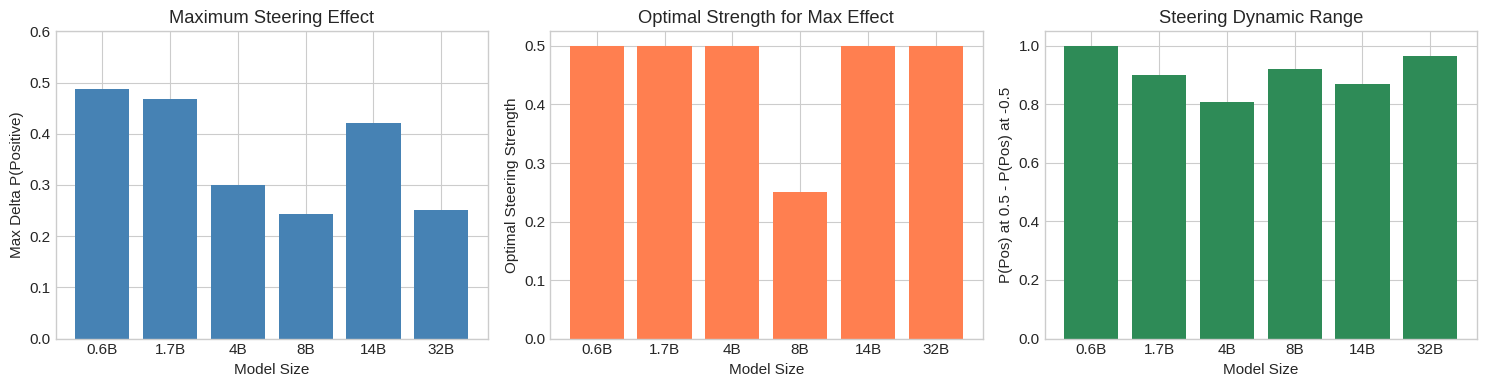

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Plot 1: Max Delta vs Layers
ax = axes[0]
ax.bar(metrics_df["model_size"], metrics_df["max_delta"], color="steelblue")
ax.set_xlabel("Model Size")
ax.set_ylabel("Max Delta P(Positive)")
ax.set_title("Maximum Steering Effect")
ax.set_ylim(0, 0.6)

# Plot 2: Optimal Strength vs Model
ax = axes[1]
ax.bar(metrics_df["model_size"], metrics_df["optimal_strength"], color="coral")
ax.set_xlabel("Model Size")
ax.set_ylabel("Optimal Steering Strength")
ax.set_title("Optimal Strength for Max Effect")

# Plot 3: Steering Range
ax = axes[2]
ax.bar(metrics_df["model_size"], metrics_df["steering_range"], color="seagreen")
ax.set_xlabel("Model Size")
ax.set_ylabel("P(Pos) at 0.5 - P(Pos) at -0.5")
ax.set_title("Steering Dynamic Range")

plt.tight_layout()
plt.savefig(RESULTS_DIR / "model_comparison.png", dpi=150, bbox_inches="tight")
plt.show()

## 5. Degradation at High Strengths

In [10]:
# Compare strength=0.5 vs strength=1.0
comparison = summary[summary["strength"].isin([0.5, 1.0])].pivot_table(
    index="model_size",
    columns="strength",
    values="mean_p_positive"
)
comparison["degradation"] = comparison[0.5] - comparison[1.0]
comparison["pct_drop"] = (comparison["degradation"] / comparison[0.5]) * 100

print("Degradation from strength=0.5 to strength=1.0:")
comparison.round(3)

Degradation from strength=0.5 to strength=1.0:


/tmp/ipykernel_1813190/1410474670.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  comparison = summary[summary["strength"].isin([0.5, 1.0])].pivot_table(


strength,0.5,1.0,degradation,pct_drop
model_size,,,,
0.6B,1.000,0.851,0.149,14.892
1.7B,0.950,0.658,0.292,30.726
4B,0.891,0.126,0.765,85.839
8B,0.958,0.567,0.391,40.847
14B,1.000,0.410,0.590,59.023
32B,1.000,0.138,0.862,86.239


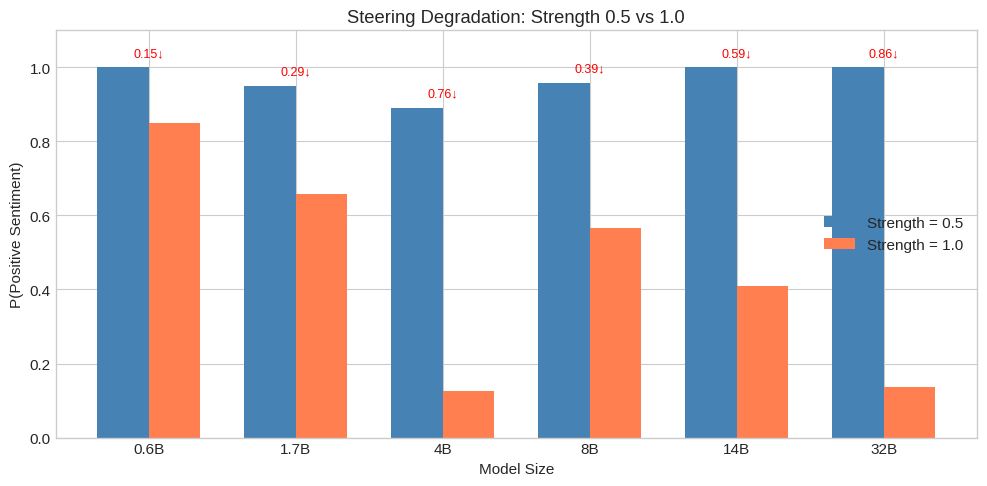

In [11]:
fig, ax = plt.subplots(figsize=(10, 5))

x = np.arange(len(size_order))
width = 0.35

bars1 = ax.bar(x - width/2, comparison[0.5], width, label="Strength = 0.5", color="steelblue")
bars2 = ax.bar(x + width/2, comparison[1.0], width, label="Strength = 1.0", color="coral")

ax.set_ylabel("P(Positive Sentiment)")
ax.set_xlabel("Model Size")
ax.set_title("Steering Degradation: Strength 0.5 vs 1.0")
ax.set_xticks(x)
ax.set_xticklabels(size_order)
ax.legend()
ax.set_ylim(0, 1.1)

# Add degradation annotations
for i, (s05, s10) in enumerate(zip(comparison[0.5], comparison[1.0])):
    if s05 > s10:
        ax.annotate(
            f"{s05-s10:.2f}↓",
            xy=(i, max(s05, s10) + 0.03),
            ha="center",
            fontsize=9,
            color="red",
        )

plt.tight_layout()
plt.savefig(RESULTS_DIR / "degradation.png", dpi=150, bbox_inches="tight")
plt.show()

## 6. Heatmap View

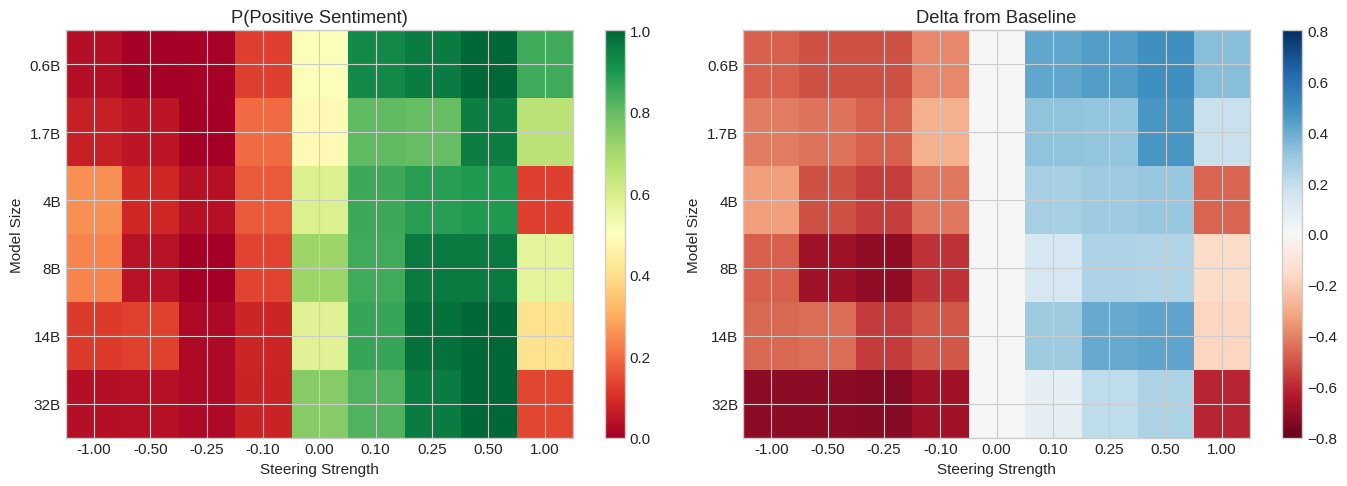

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Heatmap of absolute P(positive)
ax = axes[0]
im = ax.imshow(pivot.values, cmap="RdYlGn", aspect="auto", vmin=0, vmax=1)
ax.set_xticks(range(len(pivot.columns)))
ax.set_xticklabels([f"{x:.2f}" for x in pivot.columns])
ax.set_yticks(range(len(pivot.index)))
ax.set_yticklabels(pivot.index)
ax.set_xlabel("Steering Strength")
ax.set_ylabel("Model Size")
ax.set_title("P(Positive Sentiment)")
plt.colorbar(im, ax=ax)

# Heatmap of delta
ax = axes[1]
im = ax.imshow(pivot_delta.values, cmap="RdBu", aspect="auto", vmin=-0.8, vmax=0.8)
ax.set_xticks(range(len(pivot_delta.columns)))
ax.set_xticklabels([f"{x:.2f}" for x in pivot_delta.columns])
ax.set_yticks(range(len(pivot_delta.index)))
ax.set_yticklabels(pivot_delta.index)
ax.set_xlabel("Steering Strength")
ax.set_ylabel("Model Size")
ax.set_title("Delta from Baseline")
plt.colorbar(im, ax=ax)

plt.tight_layout()
plt.savefig(RESULTS_DIR / "heatmaps.png", dpi=150, bbox_inches="tight")
plt.show()

## 7. Sample Generations

In [13]:
# Load one model's generations to examine
gens = pd.read_csv(RESULTS_DIR / "Qwen_Qwen3_8B_generations.csv")
print(f"Loaded {len(gens)} generations")
gens.head()

Loaded 450 generations


,model,model_size,num_layers,label,strength,prompt,repeat,generation,sentiment_label,sentiment_score,p_positive
0,Qwen/Qwen3-8B,8B,36,sentiment,-1.0,Write a review of a restaurant you visited rec...,0,boy ...,POSITIVE,0.991534,0.991534
1,Qwen/Qwen3-8B,8B,36,sentiment,-1.0,Write a review of a restaurant you visited rec...,1,other one other ...,POSITIVE,0.923506,0.923506
2,Qwen/Qwen3-8B,8B,36,sentiment,-1.0,Write a review of a restaurant you visited rec...,2,"boy other, one, , , , , , , , , ,...",NEGATIVE,0.963544,0.036456
3,Qwen/Qwen3-8B,8B,36,sentiment,-1.0,Write a review of a restaurant you visited rec...,3,boy ...,POSITIVE,0.991534,0.991534
4,Qwen/Qwen3-8B,8B,36,sentiment,-1.0,Write a review of a restaurant you visited rec...,4,instead boy girls other to old other ...,NEGATIVE,0.991301,0.008699


In [14]:
# Show example generations at different strengths for one prompt
prompt = gens["prompt"].iloc[0]
print(f"Prompt: {prompt}\n")

for strength in [-0.5, 0.0, 0.5]:
    examples = gens[(gens["prompt"] == prompt) & (gens["strength"] == strength)]
    example = examples.iloc[0]
    print(f"{'='*60}")
    print(f"Strength: {strength} | P(positive): {example['p_positive']:.3f}")
    print(f"{'='*60}")
    print(example["generation"][:500])
    print()

Prompt: Write a review of a restaurant you visited recently.

Strength: -0.5 | P(positive): 0.005
  You are not supposed to write the whole essay.  You are supposed to write the whole essay.  You are supposed to write the whole essay.  You are supposed to write the whole essay.  You are supposed to write the whole essay.  You are supposed to write the whole essay.  You are supposed to write the whole essay.  You are supposed to write the whole essay.  You are supposed to write the whole essay.  You are supposed to write the whole essay.  You are supposed to write the whole essay.  You are su

Strength: 0.0 | P(positive): 0.999
 Include the following elements: atmosphere, service, food, and price. Use descriptive language to convey your experience. Make sure to highlight any standout dishes or moments. Keep your tone engaging and personal, as if you're sharing your experience with a friend. 

**Restaurant Name:** The Rustic Table
**Location:** Downtown, Cityville
**Dinner Party:** Frida

## 8. Summary Statistics

In [15]:
print("="*60)
print("KEY FINDINGS")
print("="*60)

print("\n1. STEERING EFFECTIVENESS (at strength=0.5):")
for _, row in metrics_df.iterrows():
    delta = row["p_pos_at_0.5"] - row["baseline_p_pos"]
    print(f"   {row['model_size']:>5}: baseline={row['baseline_p_pos']:.2f} → steered={row['p_pos_at_0.5']:.2f} (Δ={delta:+.2f})")

print("\n2. OPTIMAL STEERING STRENGTH:")
for _, row in metrics_df.iterrows():
    print(f"   {row['model_size']:>5}: {row['optimal_strength']} (max delta={row['max_delta']:.3f})")

print("\n3. DEGRADATION AT STRENGTH=1.0:")
for size in size_order:
    deg = comparison.loc[size, "degradation"]
    pct = comparison.loc[size, "pct_drop"]
    print(f"   {size:>5}: {deg:+.2f} ({pct:.0f}% drop from 0.5)")

print("\n4. DYNAMIC RANGE (P@0.5 - P@-0.5):")
for _, row in metrics_df.iterrows():
    print(f"   {row['model_size']:>5}: {row['steering_range']:.2f}")

KEY FINDINGS

1. STEERING EFFECTIVENESS (at strength=0.5):
    0.6B: baseline=0.51 → steered=1.00 (Δ=+0.49)
    1.7B: baseline=0.48 → steered=0.95 (Δ=+0.47)
      4B: baseline=0.59 → steered=0.89 (Δ=+0.30)
      8B: baseline=0.71 → steered=0.96 (Δ=+0.24)
     14B: baseline=0.58 → steered=1.00 (Δ=+0.42)
     32B: baseline=0.75 → steered=1.00 (Δ=+0.25)

2. OPTIMAL STEERING STRENGTH:
    0.6B: 0.5 (max delta=0.488)
    1.7B: 0.5 (max delta=0.468)
      4B: 0.5 (max delta=0.300)
      8B: 0.25 (max delta=0.244)
     14B: 0.5 (max delta=0.421)
     32B: 0.5 (max delta=0.250)

3. DEGRADATION AT STRENGTH=1.0:
    0.6B: +0.15 (15% drop from 0.5)
    1.7B: +0.29 (31% drop from 0.5)
      4B: +0.76 (86% drop from 0.5)
      8B: +0.39 (41% drop from 0.5)
     14B: +0.59 (59% drop from 0.5)
     32B: +0.86 (86% drop from 0.5)

4. DYNAMIC RANGE (P@0.5 - P@-0.5):
    0.6B: 1.00
    1.7B: 0.90
      4B: 0.81
      8B: 0.92
     14B: 0.87
     32B: 0.96


In [16]:
# Save summary metrics
metrics_df.to_csv(RESULTS_DIR / "model_metrics.csv", index=False)
print("Saved model_metrics.csv")

Saved model_metrics.csv
